In [68]:
import os
import sys
import torch
import random
import dataloader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

In [72]:
class EEGNet(nn.Module):
    def __init__(self, act_func):
        super(EEGNet, self).__init__()
        
        #FirstConv
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        #DepthwiseConv
        layer1 = [
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ]
        if act_func == 'ReLU':
            layer1.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            layer1.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            layer1.append(nn.ELU(alpha=1.0))

        layer1.append(nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0))
        layer1.append(nn.Dropout(p=0.25))
        self.depthwiseConv = nn.Sequential(*layer1)

        #SeparableConv
        layer2 = [
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
          nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ]
        if act_func == 'ReLU':
            layer2.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            layer2.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            layer2.append(nn.ELU(alpha=1.0))
            
        layer2.append(nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0))
        layer2.append(nn.Dropout(p=0.25))
        self.separableConv = nn.Sequential(*layer2)

        #Classify
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.shape[0], -1)
        x = self.classify(x)
        return x
    
print(EEGNet('ReLU'))

EEGNet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)


In [73]:
class DeepConvNet(nn.Module):
    def __init__(self, act_func):
        super(DeepConvNet, self).__init__()
        #part1
        part1 = [
            nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(1, 5)),
            nn.Conv2d(in_channels=25, out_channels=25, kernel_size=(2, 1)),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.1)
        ]
        if act_func == 'ReLU':
            part1.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            part1.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            part1.append(nn.ELU(alpha=1.0))
        part1.append(torch.nn.MaxPool2d(kernel_size=(1, 2)))
        part1.append(nn.Dropout(p=0.5))
        self.part1 = nn.Sequential(*part1)
        
        #part2
        part2 = [
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.1)
        ]
        if act_func == 'ReLU':
            part2.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            part2.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            part2.append(nn.ELU(alpha=1.0))
        part2.append(torch.nn.MaxPool2d(kernel_size=(1, 2)))
        part2.append(nn.Dropout(p=0.5))
        self.part2 = nn.Sequential(*part2)
        
        #part3
        part3 = [
            nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.1)
        ]
        if act_func == 'ReLU':
            part3.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            part3.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            part3.append(nn.ELU(alpha=1.0))
        part3.append(torch.nn.MaxPool2d(kernel_size=(1, 2)))
        part3.append(nn.Dropout(p=0.5))
        self.part3 = nn.Sequential(*part3)
        
        #part4
        part4 = [
            nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(1, 5)),
            nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.1)
        ]
        if act_func == 'ReLU':
            part4.append(nn.ReLU())
        elif act_func == 'LeakyReLU':
            part4.append(nn.LeakyReLU())
        elif act_func == 'ELU':
            part4.append(nn.ELU(alpha=1.0))
        part4.append(torch.nn.MaxPool2d(kernel_size=(1, 2)))
        part4.append(nn.Dropout(p=0.5))
        self.part4 = nn.Sequential(*part4)
       
        #Classify
        
        self.classify = nn.Sequential(
            nn.Linear(in_features=8600, out_features=2, bias=True)
        )        
    

        
    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        x = self.part4(x)
        x = x.view(x.shape[0], -1)
        x = self.classify(x)
        
        return x

print(DeepConvNet('ReLU'))

DeepConvNet(
  (part1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (part2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (part3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False

In [74]:
class DATAset(Dataset):
    def __init__(self, data):
        self.train_data, self.train_label, *_ = data
      
    def __len__(self):
        return len(self.train_data)
      
    def __getitem__(self, idx):
        return self.train_data[idx], self.train_label[idx]

In [77]:
def Train(name, network, Epoch, LR, b_size):
    batch_size = b_size
    lr = LR
    EPOCH = Epoch
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(DATAset(dataloader.read_bci_data()), batch_size=batch_size, shuffle=True, num_workers=0)
    isGPU = torch.cuda.is_available()

    network = network.cuda()
    print('========== ' + str(name) + ' ==========')


    train_accuracy, test_accuracy = [], []
    *_, test_data, test_label = dataloader.read_bci_data()
    test_data, test_label = torch.from_numpy(test_data), torch.from_numpy(test_label)
    if isGPU:
        test_data, test_label = test_data.cuda(), test_label.cuda()

    for epoch in range(1, EPOCH+1):
        accuracy_sum = 0
        for data, label in train_loader:
            if isGPU:
                data, label = data.cuda(), label.cuda()
            output = network(data)
            loss = criterion(output.float(), label.long())
            accuracy_sum += float((torch.argmax(output, dim=1) == label).sum())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          
        with torch.no_grad():
            accuracy_sum /= 1080
            train_accuracy.append([epoch, accuracy_sum])
            test_output = torch.argmax(network(test_data), dim=1)
            accuracy = float((test_output == test_label).sum()) / float(len(test_data))
            test_accuracy.append([epoch, accuracy])

        
        print(
            'Epoch:', epoch,
            '| train accuracy: %.4f' % accuracy_sum,
            '| test accuracy: %.2f' % accuracy
        )
            
    return train_accuracy, test_accuracy

In [79]:
epoch = 150
lr = 1e-2
batch_size = 64


EEG_ELU_train, EEG_ELU_test = Train('EEGNet_elu',
                                    EEGNet('ELU').double(),
                                    epoch,
                                    lr,
                                    batch_size)

EEG_ReLU_train, EEG_ReLU_test = Train('EEGNet_relu',
                                        EEGNet('ReLU').double(),
                                        epoch,
                                        lr,
                                        batch_size)

EEG_LeakyReLU_train, EEG_LeakyReLU_test = Train('EEGNet_leaky_relu',
                                                EEGNet('LeakyReLU').double(),
                                                epoch,
                                                lr,
                                                batch_size)

Deep_ELU_train, Deep_ELU_test = Train('DeepConvNet_elu',
                                        DeepConvNet('ELU').double(),
                                        epoch,
                                        lr,
                                        batch_size)

Deep_ReLU_train, Deep_ReLU_test = Train('DeepConvNet_relu',
                                        DeepConvNet('ReLU').double(),
                                        epoch,
                                        lr,
                                        batch_size)

Deep_LeakyReLU_train, Deep_LeakyReLU_test = Train('DeepConvNet_leaky_relu',
                                                    DeepConvNet('LeakyReLU').double(),
                                                    epoch,
                                                    lr,
                                                    batch_size)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
========== EEGNet_elu ==========
(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
Epoch: 1 | train accuracy: 0.6556 | test accuracy: 0.69
Epoch: 2 | train accuracy: 0.7148 | test accuracy: 0.70
Epoch: 3 | train accuracy: 0.7306 | test accuracy: 0.69
Epoch: 4 | train accuracy: 0.7269 | test accuracy: 0.71
Epoch: 5 | train accuracy: 0.7426 | test accuracy: 0.71
Epoch: 6 | train accuracy: 0.7648 | test accuracy: 0.71
Epoch: 7 | train accuracy: 0.7593 | test accuracy: 0.71
Epoch: 8 | train accuracy: 0.7556 | test accuracy: 0.72
Epoch: 9 | train accuracy: 0.7796 | test accuracy: 0.71
Epoch: 10 | train accuracy: 0.7778 | test accuracy: 0.70
Epoch: 11 | train accuracy: 0.7926 | test accuracy: 0.71
Epoch: 12 | train accuracy: 0.7991 | test accuracy: 0.72
Epoch: 13 | train accuracy: 0.7944 | test accuracy: 0.72
Epoch: 14 | train accuracy: 0.8046 | test accuracy: 0.72
Epoch: 15 | train accuracy: 0.8000 | test accuracy: 0.74
Epoch: 16 | train

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 | train accuracy: 0.5491 | test accuracy: 0.67
Epoch: 2 | train accuracy: 0.6296 | test accuracy: 0.61
Epoch: 3 | train accuracy: 0.6694 | test accuracy: 0.65
Epoch: 4 | train accuracy: 0.6648 | test accuracy: 0.66
Epoch: 5 | train accuracy: 0.6537 | test accuracy: 0.58
Epoch: 6 | train accuracy: 0.7028 | test accuracy: 0.65
Epoch: 7 | train accuracy: 0.6880 | test accuracy: 0.70
Epoch: 8 | train accuracy: 0.6889 | test accuracy: 0.62
Epoch: 9 | train accuracy: 0.6954 | test accuracy: 0.69
Epoch: 10 | train accuracy: 0.6917 | test accuracy: 0.68
Epoch: 11 | train accuracy: 0.7037 | test accuracy: 0.67
Epoch: 12 | train accuracy: 0.7148 | test accuracy: 0.69
Epoch: 13 | train accuracy: 0.6972 | test accuracy: 0.65
Epoch: 14 | train accuracy: 0.7000 | test accuracy: 0.67
Epoch: 15 | train accuracy: 0.6944 | test accuracy: 0.69
Epoch: 16 | train accuracy: 0.7269 | test accuracy: 0.63
Epoch: 17 | train accuracy: 0.6963 | test accuracy: 0.69
Epoch: 18 | train accuracy: 0.7241 | tes

In [127]:
def transfer(input):
    x=[]
    y=[]
    for i in range(len(input)):
        x.append(input[i][0])
        y.append(input[i][1])
    return x,y

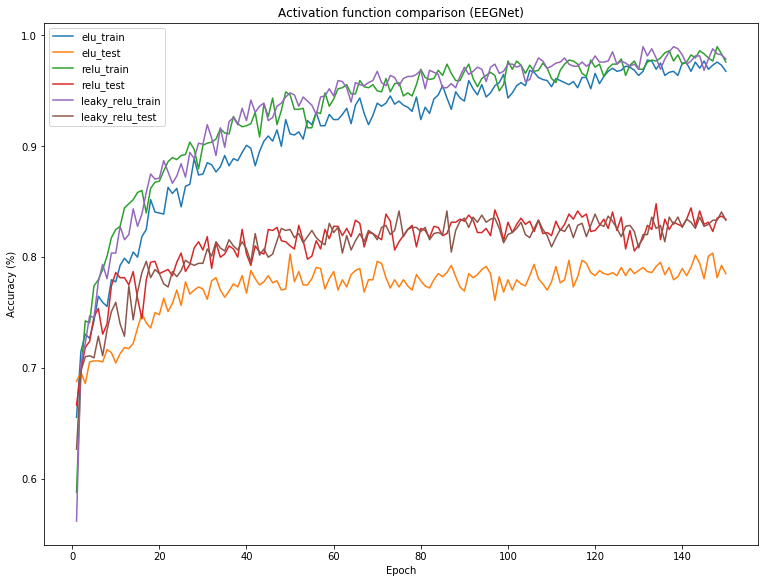

In [149]:
EEG_ELU_train_X , EEG_ELU_train_Y = transfer(EEG_ELU_train)
EEG_ELU_test_X , EEG_ELU_test_Y = transfer(EEG_ELU_test)
EEG_ReLU_train_X , EEG_ReLU_train_Y = transfer(EEG_ReLU_train)
EEG_ReLU_test_X , EEG_ReLU_test_Y = transfer(EEG_ReLU_test)
#EEG_LeakyReLU_train_X , EEG_LeakyReLU_train_Y = transfer(EEG_LeakyReLU_train)
some_mistake = []
for i in range(len(EEG_LeakyReLU_train)):
    some_mistake.append(i+1)
EEG_LeakyReLU_test_X , EEG_LeakyReLU_test_Y = transfer(EEG_LeakyReLU_test)


plt.figure(figsize=(12.8, 9.6))
plt.title("Activation function comparison (EEGNet)")
plt.ylabel("Accuracy (%)") 
plt.xlabel("Epoch")
plt.plot(EEG_ELU_train_X , EEG_ELU_train_Y , label='elu_train')
plt.plot(EEG_ELU_test_X , EEG_ELU_test_Y, label='elu_test')
plt.plot(EEG_ReLU_train_X , EEG_ReLU_train_Y, label='relu_train')
plt.plot(EEG_ReLU_test_X , EEG_ReLU_test_Y, label='relu_test')
#plt.plot(EEG_LeakyReLU_train_X , EEG_LeakyReLU_train_Y, label='leaky_relu_train')
plt.plot(some_mistake , EEG_LeakyReLU_train, label='leaky_relu_train')
plt.plot(EEG_LeakyReLU_test_X , EEG_LeakyReLU_test_Y, label='leaky_relu_test')
plt.legend()
plt.show()

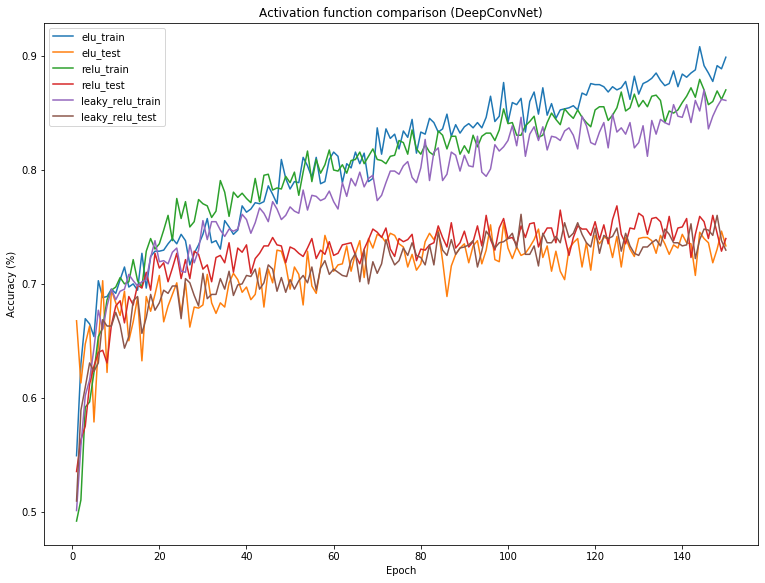

In [152]:
Deep_ELU_train_X , Deep_ELU_train_Y = transfer(Deep_ELU_train)
Deep_ELU_test_X , Deep_ELU_test_Y = transfer(Deep_ELU_test)
Deep_ReLU_train_X , Deep_ReLU_train_Y = transfer(Deep_ReLU_train)
Deep_ReLU_test_X , Deep_ReLU_test_Y = transfer(Deep_ReLU_test)
Deep_LeakyReLU_train_X , Deep_LeakyReLU_train_Y = transfer(Deep_LeakyReLU_train)
Deep_LeakyReLU_test_X , Deep_LeakyReLU_test_Y = transfer(Deep_LeakyReLU_test)


plt.figure(figsize=(12.8, 9.6))
plt.title("Activation function comparison (DeepConvNet)")
plt.ylabel("Accuracy (%)") 
plt.xlabel("Epoch")
plt.plot(Deep_ELU_train_X , Deep_ELU_train_Y , label='elu_train')
plt.plot(Deep_ELU_test_X , Deep_ELU_test_Y, label='elu_test')
plt.plot(Deep_ReLU_train_X , Deep_ReLU_train_Y, label='relu_train')
plt.plot(Deep_ReLU_test_X , Deep_ReLU_test_Y, label='relu_test')
plt.plot(Deep_LeakyReLU_train_X , Deep_LeakyReLU_train_Y, label='leaky_relu_train')
plt.plot(Deep_LeakyReLU_test_X , Deep_LeakyReLU_test_Y, label='leaky_relu_test')
plt.legend()
plt.show()